In [1]:
import sys
import os
import pandas as pd
from dotenv import load_dotenv
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../databases')))
from connections.database_connector import DatabaseConnection
from data_loader.teleco_data_loader import TelecoDataLoader
from cleaning.data_cleaning import DataCleaner
from engagement_analysis.user_engagement_analysis import UserEngagementAnalysis
from engagement_analysis.telecom_engagement_analysis import TelecomEngagementAnalysis
from experience_analytics.aggregate_customer import AggregateCustomer
from experience_analytics.network_parameter_analyzer import NetworkParameterAnalyzer
from experience_analytics.distribution_analysis import DistributionAnalysis
from experience_analytics.experience_clustering import ExperienceClustering
from satisfaction_analysis.engagement_experience_scores import EngagementExperienceScores
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
load_dotenv()

True

In [2]:
#  Initialize and connect to the database
db_connection = DatabaseConnection(
    db_name=os.getenv('DB_NAME'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT')
)
db_connection.connect()

Connection to PostgreSQL DB successful


In [3]:
# Initialize the TelecoDataLoader object with the database connection
data_loader = TelecoDataLoader(db_connection=db_connection)

# Load the data into a pandas DataFrame
df = data_loader.load_data("xdr_data")
# df = pd.DataFrame(data)

# print(df.head())

# df.info()
# Close the database connection when done
db_connection.close()

/mnt/d/tutorial/10x/tasks/task_2/customer-insights-analytics/src/data_loader/teleco_data_loader.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Connection closed.


In [4]:
# Initialize the DataCleaner object with the DataFrame
data_cleaner = DataCleaner(df)

# Clean the data
data_cleaner.clean_data()  # No need to assign, as it modifies df in place

#change kbs and bytes to mb
data_cleaner.convert_units_to_mb()

# Handle missing values and outliers
data_cleaner.handle_missing_and_outliers()

# Access the cleaned DataFrame
cleaned_df = data_cleaner.df

columns_in_bytes:  ['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)', 'Total UL (Bytes)', 'Total DL (Bytes)']
columns_in_kb:  ['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']
Unit conversion complete: Bytes and kbps columns converted to MB.
Missing values and outliers treated.


In [5]:
# Instantiate the TelecomEngagementAnalysis class
engagement_analysis = TelecomEngagementAnalysis(data=cleaned_df)

# Aggregate metrics by customer
engagement_data = engagement_analysis.aggregate_metrics_by_customer()

# Normalize metrics
normalized_data = engagement_analysis.normalize_metrics()

# Perform K-Means clustering
engagement_data_with_clusters = engagement_analysis.k_means_clustering(n_clusters=3)


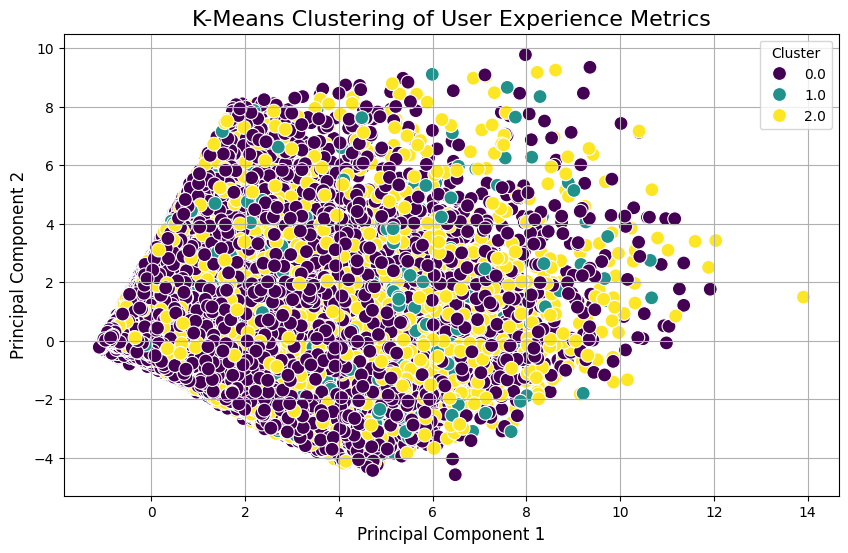

Cluster 0 characteristics:
Avg RTT DL (ms)                38.932130
Avg RTT UL (ms)                 4.154571
Avg Bearer TP DL (kbps)         0.344243
Avg Bearer TP UL (kbps)         0.032729
TCP DL Retrans. Vol (Bytes)     0.161189
TCP UL Retrans. Vol (Bytes)     0.003833
Name: 0, dtype: float64

Cluster 1 characteristics:
Avg RTT DL (ms)                144.729590
Avg RTT UL (ms)                 27.682543
Avg Bearer TP DL (kbps)          4.577843
Avg Bearer TP UL (kbps)          0.768031
TCP DL Retrans. Vol (Bytes)     29.862306
TCP UL Retrans. Vol (Bytes)      0.495996
Name: 1, dtype: float64

Cluster 2 characteristics:
Avg RTT DL (ms)                107.562259
Avg RTT UL (ms)                 25.296570
Avg Bearer TP DL (kbps)          4.929818
Avg Bearer TP UL (kbps)          0.599533
TCP DL Retrans. Vol (Bytes)      3.511665
TCP UL Retrans. Vol (Bytes)      0.063482
Name: 2, dtype: float64



In [6]:
# Instantiate the ExperienceClustering class
experience_clustering = ExperienceClustering(df=cleaned_df)

# Run the entire clustering process
experience_clustering.run()

# Retrieve clustered data
experience_data = experience_clustering.df[['MSISDN/Number', 'Cluster']]


In [7]:
# Merge engagement and experience data
user_df = pd.merge(engagement_data_with_clusters, experience_data, on='MSISDN/Number', how='inner')

# Rename 'Cluster' from experience_data to 'experience_cluster'
user_df.rename(columns={'Cluster': 'experience_cluster'}, inplace=True)

# Instantiate the EngagementExperienceScores class
engagement_clusters = engagement_analysis.kmeans  # Assuming `kmeans` is the clustering model
experience_clusters = experience_clustering.kmeans  # Assuming `kmeans` is the clustering model

satisfaction_analysis = EngagementExperienceScores(
    user_data=user_df,
    engagement_clusters=engagement_clusters,
    experience_clusters=experience_clusters
)

# Assign scores to users
user_scores_df = satisfaction_analysis.assign_scores_to_users()

# Display results
print(user_scores_df.head())


   MSISDN/Number  Dur. (ms)  Avg RTT DL (ms)  Avg RTT UL (ms)  \
0   3.360100e+10   116720.0             46.0              0.0   
1   3.360100e+10   181230.0             30.0              1.0   
2   3.360100e+10   134969.0              0.0              0.0   
3   3.360101e+10    49878.0             69.0             15.0   
4   3.360101e+10    37104.0             57.0              2.5   

   Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  Total DL (Bytes)  \
0                 0.004625                 0.004875        842.637466   
1                 0.006000                 0.006375        120.755184   
2                 0.006000                 0.006125        556.659663   
3                 0.025500                 0.005500        401.993172   
4                 2.524688                 1.028062       1363.130417   

   Total UL (Bytes)  Cluster_x  Cluster_y  engagement_score  experience_score  
0         36.053108          0          0     116723.357168         46.222942  
1         

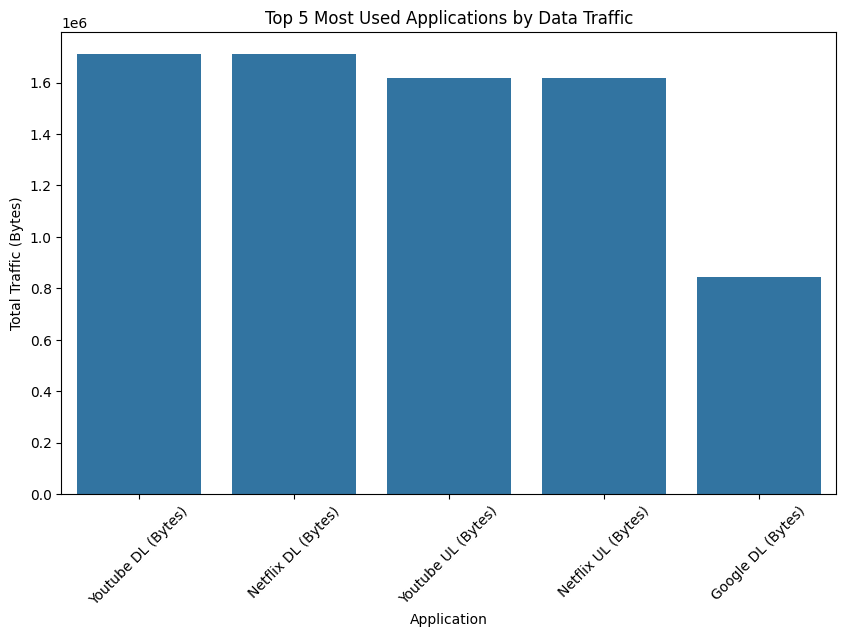

In [8]:
# If you have any visualizations, plot them here
# Example: Plotting top applications
engagement_analysis.plot_top_applications(top_n=5)
